<a href="https://www.kaggle.com/code/threeminutesgameplay/house-prices-advanced-regression?scriptVersionId=227385110" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/houseprices-new/sample_submission.csv
/kaggle/input/houseprices-new/train.csv
/kaggle/input/houseprices-new/test.csv


In [2]:
# Import data set 
data=pd.read_csv('/kaggle/input/houseprices-new/train.csv')
data_test=pd.read_csv('/kaggle/input/houseprices-new/test.csv')
data_submission=pd.read_csv('/kaggle/input/houseprices-new/sample_submission.csv')

both_data=[data,data_test]

In [3]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import make_scorer, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pylab
from scipy import stats
from xgboost import XGBRegressor

In [4]:
data.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

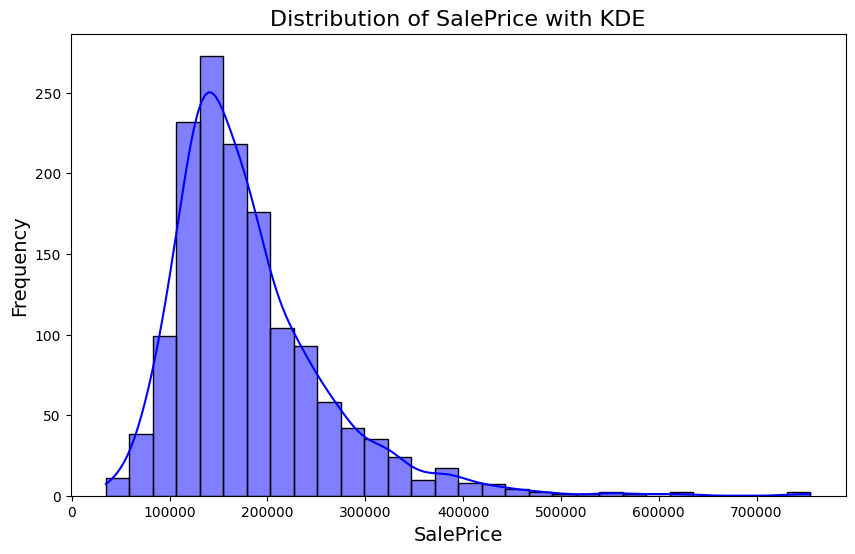

In [6]:
# SalePrice plot
plt.figure(figsize=(10, 6))
sns.histplot(data['SalePrice'], kde=True, bins=30, color='blue')

# Add labels and title
plt.title('Distribution of SalePrice with KDE', fontsize=16)
plt.xlabel('SalePrice', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.show()

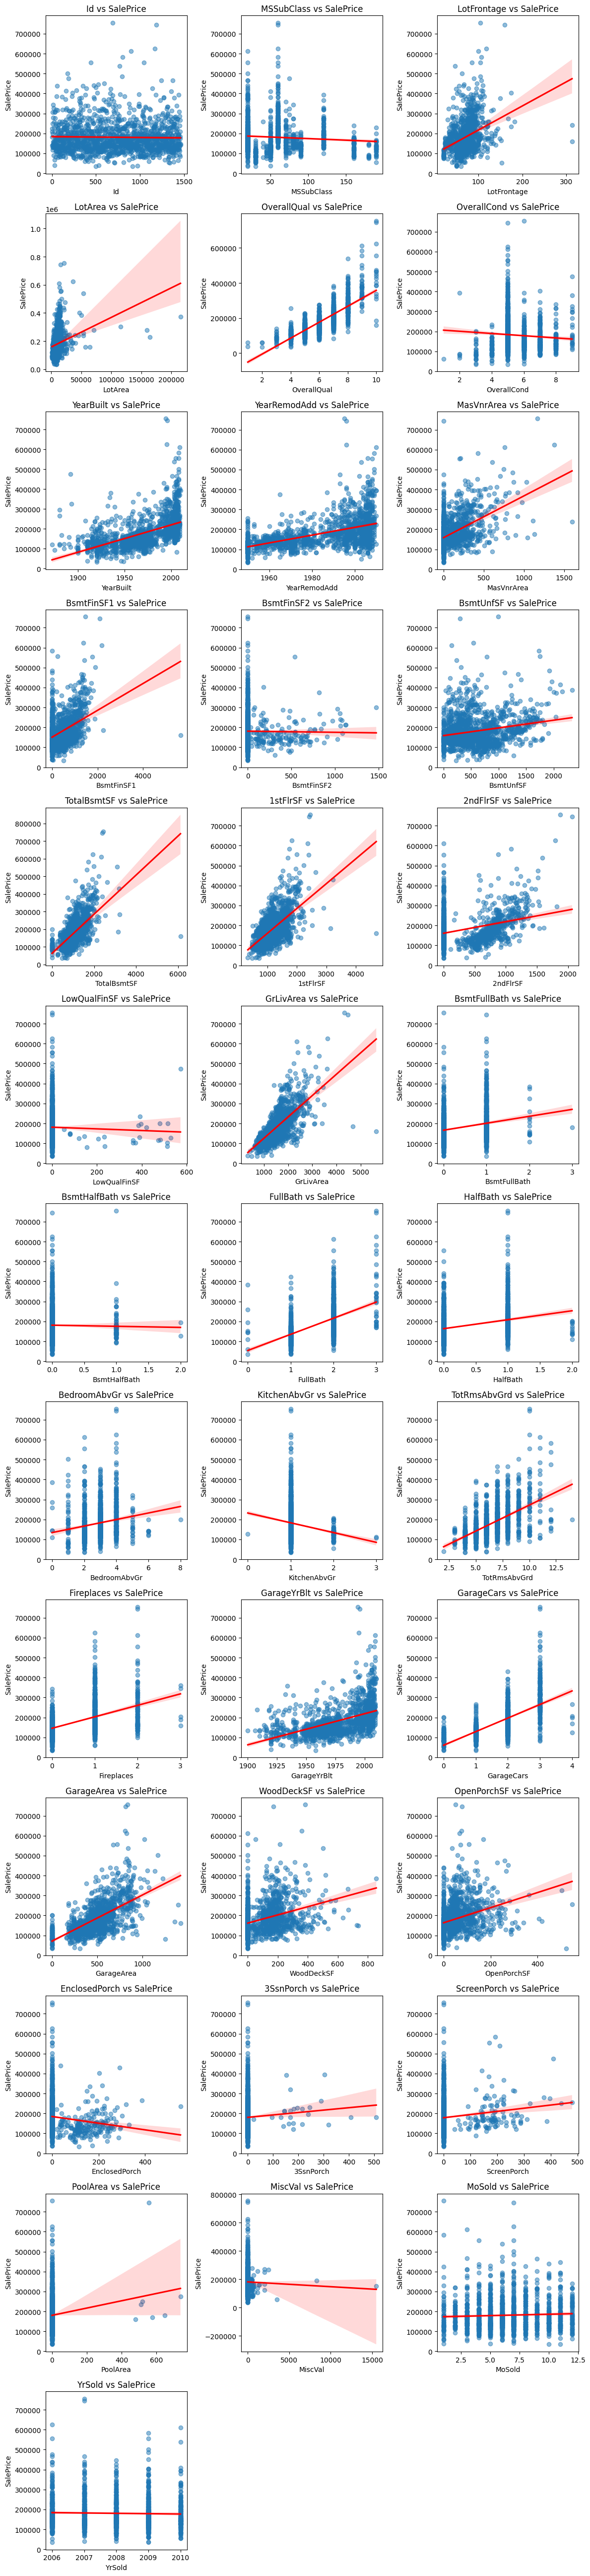

In [7]:
# Checking linearity using scatterplot
# Select numerical columns 
numerical_columns = data.select_dtypes(include=['number']).columns
target = "SalePrice"  # Change this if your target variable is different

# Remove target from numerical columns to avoid plotting SalePrice vs. itself
numerical_columns = [col for col in numerical_columns if col != target]

# Define grid size for subplots
cols = 3  
num_plots = len(numerical_columns)  # Total number of features
rows = (num_plots // cols) + (num_plots % cols > 0)  # Ensure enough rows

# Create subplots dynamically
fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))  # Adjust size for readability
axes = axes.flatten()  # Flatten for easy iteration

# Scatter plots with trendline
for i, col in enumerate(numerical_columns):
    sns.regplot(x=data[col], y=data[target], ax=axes[i], scatter_kws={"alpha": 0.5}, line_kws={"color": "red"})
    axes[i].set_title(f'{col} vs {target}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel(target)

# Hide extra unused subplots
for i in range(num_plots, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

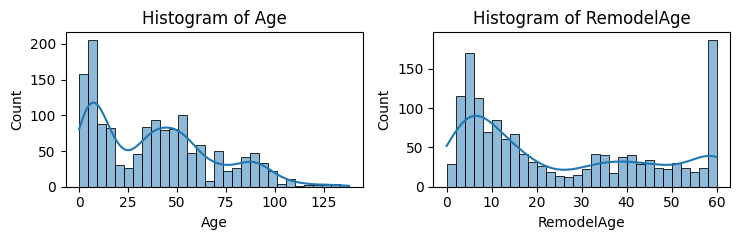

In [8]:
# Transform YearBuilt and YearRemodelAdd into Age and RemodelAge
current_year = data['YrSold'].max()  # Get the latest sale year

# Create new age-related features
for i in both_data: # apply on data & data_test
    i['Age'] = current_year - i['YearBuilt']
    i['RemodelAge'] = current_year - i['YearRemodAdd']

# Plot the new Age & RemodelAge Feature
age_remodel=['Age','RemodelAge']
fig, axes = plt.subplots(1, 2, figsize=(7.5, 2.5))  # 1 row, 2 columns

for i,col in enumerate(age_remodel):
    sns.histplot(data=data, x=col, bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Histogram of {col}')

plt.tight_layout()
plt.show()

In [9]:
# Drop Year columns
for i in both_data: # apply on data & data_test
    i.drop(columns=['YearBuilt', 'YearRemodAdd'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 83 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [10]:
# Categorical Features with null values
# This Ensures that categorical values are not too diverse to be usefull for prediction
cat_obj_cols = data.select_dtypes(include=['category', 'object'])
null_features_cat = cat_obj_cols.columns[cat_obj_cols.isnull().any()].tolist()

# Convert to DataFrame for better display
pd.DataFrame({
    "Feature": null_features_cat,  # Feature names
    "Value Count": data[null_features_cat].count().values,  # Count of values
    "Missing Count": data[null_features_cat].isnull().sum().values,  # Count of values
    "Unique Count": data[null_features_cat].nunique().values  # Count of unique values
})

,Feature,Value Count,Missing Count,Unique Count
0,Alley,91,1369,2
1,MasVnrType,588,872,3
2,BsmtQual,1423,37,4
3,BsmtCond,1423,37,4
4,BsmtExposure,1422,38,4
5,BsmtFinType1,1423,37,6
6,BsmtFinType2,1422,38,6
7,Electrical,1459,1,5
8,FireplaceQu,770,690,5
9,GarageType,1379,81,6


In [11]:
#Pool QC have 3 different type, with only 7 value
#Misc Feature too anonymous with very low quantity of data to be meaningful
for i in both_data: # apply on data & data_test
    i.drop(columns=['PoolQC','MiscFeature'],inplace=True)

In [12]:
# Check further for Type of Alley Access and Fence Quality
print("Unique values in 'alley':", ', '.join(map(str, data['Alley'].unique())))
print("Unique values in 'fence':", ', '.join(map(str, data['Fence'].unique())))

Unique values in 'alley': nan, Grvl, Pave
Unique values in 'fence': nan, MnPrv, GdWo, GdPrv, MnWw


Fence : Fence Quality
GdPrv	Good Privacy
       MnPrv	Minimum Privacy
       GdWo	Good Wood
       MnWw	Minimum Wood/Wire
       NA	No Fence
Ordinal relationship for fence

Alley: Type of alley access to property
       Grvl	Gravel
       Pave	Paved
       NA 	No alley access
Ordinal relationship for alley 
This is meaningful even with small data present, feature will be kept and Null Value will be set 0 (lowest order)

In [13]:
# Mapping for fence and alley
# Apply Fence mapping
for i in both_data: # apply on data & data_test
    i['Fence'] = i['Fence'].map({'MnWw': 1, 'MnPrv':2,'GdWo':3,'GdPrv':4})
    i['Fence'].fillna(0, inplace=True)
    i['Alley'] = i['Alley'].map({'Grvl':1,'Pave':2})
    i['Alley'].fillna(0, inplace=True)
print(data['Fence'].unique())
print(data['Alley'].unique())

[0. 2. 3. 4. 1.]
[0. 1. 2.]


In [14]:
#Check for these categorical , wether to OHE or Ordinal According to Price
#apply to data and data_test
for i in both_data: # apply on data & data_test
#1	MasVnrType
#NA , CBlock, BrkCmn, BrkFace , Stone > Ord
    i['MasVnrType'] =i['MasVnrType'].map({'CBlock':1,'BrkCmn':2,'BrkFace':3,'Stone':4})
#4	BsmtExposure	
#NA,No, Mn, Av, Gd > Ord
    i['BsmtExposure']=i['BsmtExposure'].map({'No':1,'Mn':2,'Av':3,'Gd':4})
#7	Electrical << There is missing count 1 for this value, will be filled with mode
#FuseP, FuseF, FuseA, Mix, SBrkr > Ord
    i['Electrical']=i['Electrical'].map({'FuseP':1,'FuseF':2,'FuseA':3,'Mix':4,'SBrkr':4})
#9	GarageType 
#NA, CarPort, Detchd, Basment, Attchd, BuiltIn, 2Types > Ord
    i['GarageType']=data['GarageType'].map({'CarPort':1,'Detchd':2,'Basment':3,'Attchd':4,'BuiltIn':5,'2Types':6})
#10	GarageFinish	
#NA, Unf, RFn, Fin > Ord
    i['GarageFinish']=data['GarageFinish'].map({'Unf':1,'RFn':2,'Fin':3})
#5	BsmtFinType1	
#NA, Unf, LwQ, Rec, BLQ, ALQ, GLQ > Ord
    i['BsmtFinType1']=data['BsmtFinType1'].map({'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6})
#6	BsmtFinType2	
#NA, Unf, LwQ, Rec, BLQ, ALQ, GLQ > Ord
    i['BsmtFinType2']=data['BsmtFinType2'].map({'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6})
#2	BsmtQual	
#NA, Po, Fa, TA, Gd, Ex > Ord
#3	BsmtCond	
#NA, Po, Fa, TA, Gd, Ex > Ord
#11	GarageQual	
#NA, Po, Fa, TA, Gd, Ex > Ord
#12	GarageCond	
#NA, Po, Fa, TA, Gd, Ex > Ord
#8	FireplaceQu	
#NA, Po, Fa, TA, Gd, Ex > Ord
    same_col5=['BsmtQual','BsmtCond','GarageQual','GarageCond','FireplaceQu']
    for col in same_col5:
        i[col]=i[col].map({'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})

# Show only columns with missing values
missing_features = data.isnull().sum()
missing_features = missing_features[missing_features > 0]  # Keep only features with missing values

# Display the features and their missing count
print(missing_features)


LotFrontage     259
MasVnrType      872
MasVnrArea        8
BsmtQual         37
BsmtCond         37
BsmtExposure     38
BsmtFinType1     37
BsmtFinType2     38
Electrical        1
FireplaceQu     690
GarageType       81
GarageYrBlt      81
GarageFinish     81
GarageQual       81
GarageCond       81
dtype: int64


In [15]:
# Fill NA with 0 for all of the categorical columns above Except Electrical
remove_items = ['Alley','Electrical','PoolQC','Fence','MiscFeature']
same_null11 = [col for col in null_features_cat if col not in remove_items]
for i in both_data: # apply on data & data_test
    for col in same_null11:
        i[col].fillna(0, inplace=True)
        
# Fill Electrical with mode
    i['Electrical'].fillna(i['Electrical'].mode()[0], inplace=True)
print(i[col].unique())
print(i['Electrical'].unique())

[3. 0. 2. 4. 1. 5.]
[4 3 2 1]


In [16]:
# Handling Null values for numerical columns
num_obj_cols = data.select_dtypes(include=['int64', 'float64'])
null_features_num = num_obj_cols.columns[num_obj_cols.isnull().any()].tolist()

# Convert to DataFrame for better display
pd.DataFrame({
    "Feature": null_features_num,  # Feature names
    "Value Count": data[null_features_num].count().values,  # Count of values
    "Missing Count": data[null_features_num].isnull().sum().values,  # Count of values
    "Unique Count": data[null_features_num].nunique().values  # Count of unique values
})

,Feature,Value Count,Missing Count,Unique Count
0,LotFrontage,1201,259,110
1,MasVnrArea,1452,8,327
2,GarageYrBlt,1379,81,97


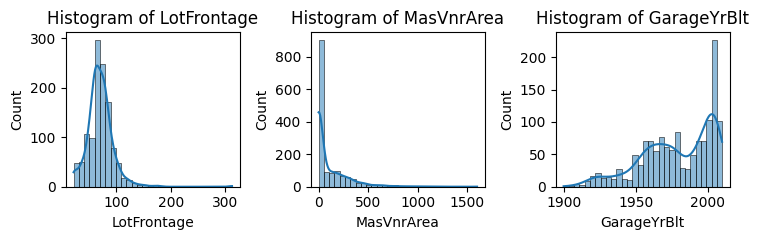

In [17]:
# Lets plot the distribution for these missing values
missing_numerical=['LotFrontage','MasVnrArea','GarageYrBlt']
fig, axes = plt.subplots(1, 3, figsize=(7.5, 2.5))  # 1 row, 3 columns
for i,col in enumerate(missing_numerical):
    sns.histplot(data=data, x=col, bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Histogram of {col}')

plt.tight_layout()
plt.show()

In [18]:
# LotFrontage is approximately normal, MasVnrArea and GarageYrBlt are skewed
# fillna with respective values
for i in both_data: # apply on data & data_test
    i['LotFrontage'].fillna(i['LotFrontage'].mean(), inplace=True)
    i['MasVnrArea'].fillna(i['MasVnrArea'].median(), inplace=True)
    i['GarageYrBlt'].fillna(i['GarageYrBlt'].median(), inplace=True)

# There will be no more null values
data.isnull().values.any()

False

In [19]:
# Check further for Type of LandContour HouseStyle Exterior2nd SaleCondition since the 
# value in web is incorrect
check_uniqueLHES=['LandContour','HouseStyle','Exterior2nd','SaleCondition']
for i in check_uniqueLHES:
    print(f"Unique values in {i} :", ', '.join(map(str, data[i].unique())))

Unique values in LandContour : Lvl, Bnk, Low, HLS
Unique values in HouseStyle : 2Story, 1Story, 1.5Fin, 1.5Unf, SFoyer, SLvl, 2.5Unf, 2.5Fin
Unique values in Exterior2nd : VinylSd, MetalSd, Wd Shng, HdBoard, Plywood, Wd Sdng, CmentBd, BrkFace, Stucco, AsbShng, Brk Cmn, ImStucc, AsphShn, Stone, Other, CBlock
Unique values in SaleCondition : Normal, Abnorml, Partial, AdjLand, Alloca, Family


In [20]:
# Get the rest of categorical features
categorical_features = data.select_dtypes(include=['object', 'category']).columns
categorical_features

# Identifying ordinal / nominal categorical features & Map Ordinal Features
for i in both_data: # apply on data & data_test
#'Street', Ordinal
# Pave, Grvl      
    i['Street']=i['Street'].map({'Pave':0,'Grvl':1})
#'LandContour', custom ordinal
#Low, HLS 0.9, Bnk 1.1, Lv1
    i['LandContour']=i['LandContour'].map({'Low':0,'HLS':0.9,'Bnk':1.1,'Lvl':2})
#'Utilities', ordinal
#ELO, NoSeWa, NoSewr, AllPub
    i['Utilities']=i['Utilities'].map({'ELO':0,'NoSeWa':1,'NoSewr':2,'AllPub':3})
#'LandSlope', ordinal
# Sev, Mod, Gtl
    i['LandSlope']=i['LandSlope'].map({'Sev':0,'Mod':1,'Gtl':2})
#'HouseStyle', 
# 1Story, 1.5Unf, 1.5Fin , SLvl 2.2, SFoyer 2.2, 2Story, 2.5Unf, 2.5Fin
    i['HouseStyle']=i['HouseStyle'].map({'1Story':0,'1.5Unf':1,'1.5Fin':2,'SLvl':2.2,'SFoyer':2.2,'2Story':3,'2.5Unf':4,'2.5Fin':5})
#'RoofStyle', 
#Flat , Shed, Gable, Gambrel, Hip, Mansard
    i['RoofStyle']=i['RoofStyle'].map({'Flat':0,'Shed':1,'Gable':2,'Gambrel':3,'Hip':4,'Mansard':5})
#'RoofMatl', 
#Roll, Tar&Grv, Membran, CompShg, WdShngl, WdShake, Metal, ClyTile
    i['RoofMatl']=i['RoofMatl'].map({'Roll':0,'Tar&Grv':1,'Membran':2,'CompShg':3,'WdShngl':4,'WdShake':5,'Metal':6,'ClyTile':7})
#'Exterior1st',
#CBlock, Plywood, Other, AsbShng, HdBoard, PreCast, ImStucc, MetalSd, VinylSd, 
#AsphShn, Stucco, Wd Sdng, WdShing, CemntBd, BrkComm, BrkFace, Stone
    i['Exterior1st']=i['Exterior1st'].map({'CBlock':0,'Plywood':1,'Other':2,'AsbShng':3,'HdBoard':4,'PreCast':5,'ImStucc':6,'MetalSd':7,'VinylSd':8,
                                      'AsphShn':9,'Stucco':10,'Wd Sdng':11,'WdShing':12,'CemntBd':13,'BrkComm':14,'BrkFace':15,'Stone':16})
#'Exterior2nd', 
#CBlock, Plywood, Other, AsbShng, HdBoard, PreCast, ImStucc, MetalSd, VinylSd, 
#AsphShn, Stucco, Wd Sdng, Wd Shng, CmentBd, Brk Cmn, BrkFace, Stone
    i['Exterior2nd']=i['Exterior2nd'].map({'CBlock':0,'Plywood':1,'Other':2,'AsbShng':3,'HdBoard':4,'PreCast':5,'ImStucc':6,'MetalSd':7,'VinylSd':8,
                                      'AsphShn':9,'Stucco':10,'Wd Sdng':11,'Wd Shng':12,'CmentBd':13,'Brk Cmn':14,'BrkFace':15,'Stone':16})
#'Foundation', 
#Slab, CBlock, Wood, PConc, BrkTil, Stone
    i['Foundation']=i['Foundation'].map({'Slab':0,'CBlock':1,'Wood':2,'PConc':3,'BrkTil':4,'Stone':5})
#'Heating',
#Grav, Wall, Floor, OthW, GasW, GasA
    i['Heating']=i['Heating'].map({'Grav':0,'Wall':1,'Floor':2,'OthW':3,'GasW':4,'GasA':5})
#'CentralAir', 
#N, Y
    i['CentralAir']=i['CentralAir'].map({'N':0,'Y':1})
#'Functional', 
#Sal, Sev, Maj2, Maj1, Mod, Min2, Min1, Typ
    i['Functional']=i['Functional'].map({'Sal':0,'Sev':1,'Maj2':2,'Maj1':3,'Mod':4,'Min2':5,'Min1':6,'Typ':7})
#'PavedDrive',
#N,P,Y
    i['PavedDrive']=i['PavedDrive'].map({'N':0,'P':1,'Y':2})
#'SaleType', 
#COD, Oth, ConLD, ConLI, ConLw, Con, VWD, CWD, WD, New
    i['SaleType']=i['SaleType'].map({'COD':0,'Oth':1,'ConLD':2,'ConLI':3,'ConLw':4,'Con':5,'VWD':6,'CWD':7,'WD':8,'New':9})
#'SaleCondition'
#Abnorml, Family, AdjLand, Alloca, Partial, Normal
    i['SaleCondition']=i['SaleCondition'].map({'Abnorml':0,'Family':1,'AdjLand':2,'Alloca':3,'Partial':4,'Normal':5})
#'HeatingQC', 
#Po, Fa, TA, Gd, Ex
#'KitchenQual', 
#Po, Fa, TA, Gd, Ex
#'ExterQual', 
#Po, Fa, TA, Gd, Ex
#'ExterCond', 
#Po, Fa, TA, Gd, Ex
    same_col4=['HeatingQC','KitchenQual','ExterQual','ExterCond']
    for col in same_col4:
        i[col]=i[col].map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
#'MSZoning', Nominal
#'LotShape', nominal
#'LotConfig', nominal
#'Neighborhood', nominal
#'Condition1', nominal
#'Condition2', nom
#'BldgType', nom
nominal_category=['MSZoning','LotShape','LotConfig','Neighborhood','Condition1','Condition2','BldgType']
data = pd.get_dummies(data, columns=nominal_category, drop_first=True, dtype=int)
data_test = pd.get_dummies(data_test, columns=nominal_category, drop_first=True, dtype=int)
data.shape

(1460, 128)

In [21]:
# There is mis information in website that need changes ( wrong feature unique values )
data.isnull().sum()[data.isnull().sum() > 0]

Series([], dtype: int64)

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 128 entries, Id to BldgType_TwnhsE
dtypes: float64(19), int64(109)
memory usage: 1.4 MB


In [23]:
# Checking correlation before transforming features
# Correlation only with SalePrice
correlation_with_saleprice = data.corr()["SalePrice"].sort_values(ascending=False)
pd.set_option("display.max_rows", None)
print(correlation_with_saleprice)

SalePrice               1.000000
OverallQual             0.790982
GrLivArea               0.708624
ExterQual               0.682639
KitchenQual             0.659600
GarageCars              0.640409
GarageArea              0.623431
TotalBsmtSF             0.613581
1stFlrSF                0.605852
BsmtQual                0.585207
FullBath                0.560664
GarageFinish            0.549247
TotRmsAbvGrd            0.533723
YearBuilt               0.522897
FireplaceQu             0.520438
YearRemodAdd            0.507101
GarageType              0.478885
MasVnrArea              0.472614
Fireplaces              0.466929
GarageYrBlt             0.466754
HeatingQC               0.427649
Neighborhood_NridgHt    0.402149
MasVnrType              0.401151
BsmtFinSF1              0.386420
BsmtExposure            0.374696
LotFrontage             0.334901
Neighborhood_NoRidge    0.330424
WoodDeckSF              0.324413
2ndFlrSF                0.319334
OpenPorchSF             0.315856
BsmtFinTyp

In [24]:
# add constant for data & data_test
data = sm.add_constant(data, has_constant='add')
data_test = sm.add_constant(data_test, has_constant='add')
# Check for NaN Value for data_test and fill NA with mode
for column in data_test.columns:
    mode_value = data_test[column].mode()[0]  # Get the most frequent value
    data_test[column].fillna(mode_value, inplace=True)  # Fill missing values
data_test.isnull().any().sum()

0

In [25]:
# MODEL BUILDING

# 🔹 Define Features (X) and Target (y)
x = data.drop(columns=['SalePrice'])  # Replace 'SalePrice' with your target column
y = data['SalePrice']
x= sm.add_constant(x)

# 🔹 Split into Train and Test Sets (80% Train, 20% Test)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

# 🔹 Print Shapes to Confirm
print(f"x_train Shape: {x_train.shape}, x_test Shape: {x_test.shape}")
print(f"y_train Shape: {y_train.shape}, y_test Shape: {y_test.shape}")

x_train Shape: (1168, 128), x_test Shape: (292, 128)
y_train Shape: (1168,), y_test Shape: (292,)


In [26]:
# Regression metrics function
def adj_r2(predictors, target, predictions):
    r2 = r2_score(target,predictions)
    n,k=predictors.shape
    return 1-((1-r2)*(n-1)/(n-k-1))

def mape_score(targets,predictions):
    return np.mean(np.abs(targets-predictions)/targets)* 100

# performance metric for train and test data
def model_performance_regression(model, predictors, target):
    pred = model.predict(predictors)
    
    r2 = r2_score(target, pred)
    adjr2 = adj_r2(predictors, target, pred)
    rmse = np.sqrt(mean_squared_error(target, pred))
    mae = mean_absolute_error(target, pred)
    mape = mape_score(target, pred)
        
    df_perf=pd.DataFrame ({
        "R2":r2,
        "Adj-R2":adjr2,
        "RMSE":rmse,
        "MAE":mae,
        "MAPE":mape
    }, index=[0]
                         )
    return df_perf

# Using performance metrics to apply to both test for overfitting comparison
def tt_performance_regression(x_train, y_train, x_test, y_test, model=None):
    if model == None:
        model = LinearRegression()
    else:
        model = model
        
    model.fit(x_train, y_train)
    x_test = x_test[x_train.columns] # ensuring both train and test have same column
    # Compute performance for training and test sets
    df_train = model_performance_regression(model, x_train, y_train)
    df_test = model_performance_regression(model, x_test, y_test)
    
    # Combine results into a single DataFrame
    df_perf = pd.concat([df_train, df_test], ignore_index=True)
    
    # Rename index to "Train" and "Test"
    df_perf.index = ["Train", "Test"]
    
    return df_perf, model

In [27]:
# Check missing values
missing_features = x_test.isnull().sum()
missing_features = missing_features[missing_features > 0]  # features with missing values

# Display the features and their missing count
print(missing_features)

Series([], dtype: int64)


In [28]:
# Display performance evaluation metrics for train and test
result, model_benchmark = tt_performance_regression(x_train, y_train, x_test, y_test)
result
# Benchmark performance without any feature engineering

,R2,Adj-R2,RMSE,MAE,MAPE
Train,0.883584,0.869242,26631.361647,17193.977678,9.96352
Test,0.845930,0.724943,33148.431658,20629.522739,12.68242


MODEL BENCHMARK
_________________________________________________________________________________
CUSTOM MODEL BUILDING

In [29]:
# Do OLS to get better statistical summary

ols_model = sm.OLS(y_train, x_train).fit()  
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     64.42
Date:                Thu, 13 Mar 2025   Prob (F-statistic):               0.00
Time:                        11:23:31   Log-Likelihood:                -13559.
No. Observations:                1168   AIC:                         2.737e+04
Df Residuals:                    1044   BIC:                         2.799e+04
Df Model:                         123                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0929      0.338      0.275      0.784      -0.571       0.757
Id                      -0.3747      2.064     -0.182      0.856      -4.424       3.675
MSSubClass             -36.8438     92.981     -0.396      0.692    -219.295     145.607
LotFrontage           -180.2327     55.204     -3.265      0.001    -288.557     -71.908
LotArea                  0.5641      0.124      4.557      0.000       0.321       0.807
Street                1.029e+04   1.93e+04      0.532      0.595   -2.76e+04    4.82e+04
Alley                 1960.7442   2812.962      0.697      0.486   -3558.958    7480.447
LandContour           5021.4615   3040.293      1.652      0.099    -944.319     1.1e+04
Utilities             2.192e+04   1.56e+04      1.406      0.160   -8674.346    5.25e+04
LandSlope             1621.8892   4821.318      0.336      0.737   -7838.688    1.11e+04
HouseStyle           -6413.1694   2253.788     -2.846      0.005   -1.08e+04   -1990.700
OverallQual           8429.9195   1293.242      6.518      0.000    5892.269     1.1e+04
OverallCond           5387.7681   1137.535      4.736      0.000    3155.653    7619.883
YearBuilt              253.1766    340.166      0.744      0.457    -414.310     920.663
YearRemodAdd            60.4684    342.950      0.176      0.860    -612.481     733.418
RoofStyle             3194.5784   1155.199      2.765      0.006     927.801    5461.356
RoofMatl             -1.567e+04   3678.229     -4.261      0.000   -2.29e+04   -8454.006
Exterior1st            360.9139    501.891      0.719      0.472    -623.917    1345.745
Exterior2nd            373.6669    488.643      0.765      0.445    -585.167    1332.501
MasVnrType           -1805.4936    860.259     -2.099      0.036   -3493.527    -117.460
MasVnrArea              19.6228      7.603      2.581      0.010       4.705      34.541
ExterQual             1.067e+04   2758.511      3.867      0.000    5253.645    1.61e+04
ExterCond            -4046.5264   2787.767     -1.452      0.147   -9516.791    1423.738
Foundation           -2370.1534   1128.381     -2.100      0.036   -4584.306    -156.000
BsmtQual              6607.0755   2147.127      3.077      0.002    2393.900    1.08e+04
BsmtCond             -6404.0656   2613.520     -2.450      0.014   -1.15e+04   -1275.715
BsmtExposure          7435.2950   1086.921      6.841      0.000    5302.496    9568.094
BsmtFinType1           943.0859    671.441      1.405      0.160    -374.442    2260.614
BsmtFinSF1               4.7689      3.393      1.406      0.160      -1.889      11.427
BsmtFinType2           504.5743   1785.489      0.283      0.778   -2998.982    4008.131
BsmtFinSF2              -2.7266      7.172     -0.380      0.704     -16.799      11.346
BsmtUnfSF               -1.3219      3.202     -0.413    

In [30]:
# Linear Regression Assumption, Independent Residual with Mean 0
np.mean(ols_model.resid)

# It fulfilled, since it is so close to 0

5.297345661060655e-09

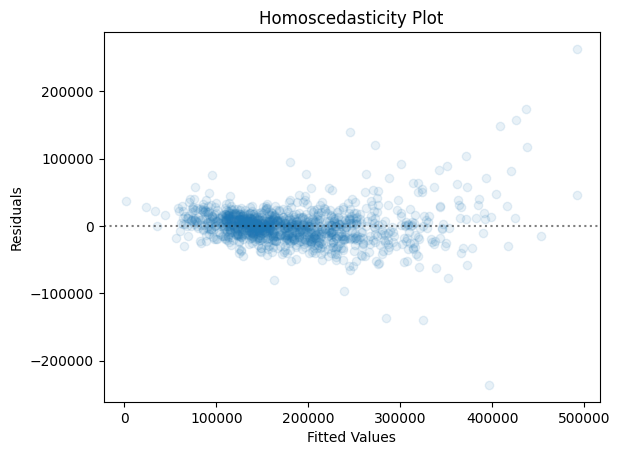

In [31]:
#### Linear Regression Assumption, Homoscedasticity
plt.scatter(ols_model.fittedvalues,ols_model.resid, alpha=0.1)
plt.axhline(0, color='black', alpha=0.5, linestyle='dotted');
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Homoscedasticity Plot');

In [32]:
homoscedasticity_result = sms.het_goldfeldquandt(y_train, x_train)
homoscedasticity_result[1]

# The result is > 0.05 , the model is homoscedastic

0.4756709619246998

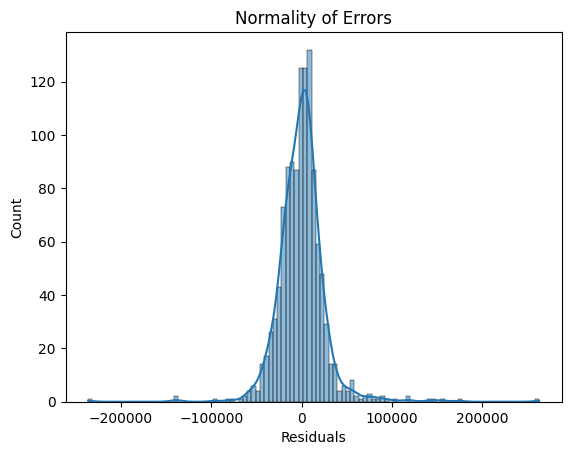

In [33]:
# Assumption 3 Normality of Errors 
sns.histplot(ols_model.resid, kde=True)
plt.xlabel('Residuals')
plt.title('Normality of Errors');

((array([-3.24209521, -2.98025416, -2.83435097, ...,  2.83435097,
          2.98025416,  3.24209521]),
  array([-236110.78762077, -140078.8327325 , -137295.17781794, ...,
          157202.34497856,  174437.06965792,  262978.36612277])),
 (24425.731628682897, 5.302043451254934e-09, 0.9149551909088385))

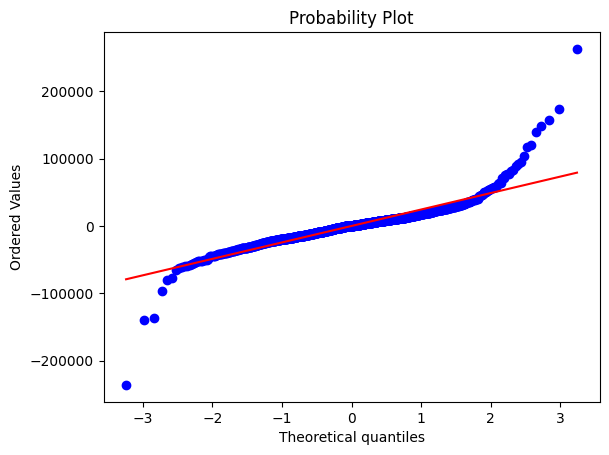

In [34]:
# QQ plot for normality check 2

stats.probplot(ols_model.resid, dist='norm', plot=pylab)

# This confirms that the residual is normally distributed ( majority is in the mean line)

TEST 1 : BUILDING A MODEL WITHOUT FEATURE TRANSFORMATION

In [35]:
# P-value and VIF Filter function
def ols_pvfilter(x, y, p=0.05, vif=10, verbose=True):
    # Fit the initial OLS model
    ols_model = sm.OLS(y, x).fit()
    x = sm.add_constant(x)

    while True:
        p_values = ols_model.pvalues.drop('const', errors='ignore')  # get P, ignore const
        max_p = p_values.max()  # Find the highest p-value
    
        # Remove features with p-value > 0.05
        if max_p > p:  
            feature_to_remove = p_values.idxmax()  # Identify feature to remove
            print(f"Removing {feature_to_remove} (p={max_p:.5f})| R²: {ols_model.rsquared:.5f}")

            # Drop the feature 
            x = x.drop(columns=[feature_to_remove])

            # Refit the model with the updated feature set
            ols_model = sm.OLS(y, x).fit()
            continue  # Restart loop to check p-values again

        # Compute VIF after p-value filtering
        vif_data = pd.DataFrame()
        vif_data["Feature"] = x.columns
        vif_data["VIF"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]

        vif_data = vif_data[vif_data["Feature"] != 'const'] # ignore constant
        max_vif = vif_data["VIF"].max()  # Find the highest VIF

        # Remove features with VIF > 10
        if max_vif > vif:
            feature_to_remove = vif_data.loc[vif_data["VIF"].idxmax(), "Feature"]
            print(f"Removing {feature_to_remove} (VIF={max_vif:.5f})| R²: {ols_model.rsquared:.5f}")

            # Drop the feature 
            x = x.drop(columns=[feature_to_remove])

            # Refit the model with the updated feature set
            ols_model = sm.OLS(y, x).fit()
            continue  # Restart loop to check p-values again

        # Stop if no more features violate p-value and VIF thresholds
        break 

    print(ols_model.summary())

    return ols_model, x


In [36]:
# filter the p-value and VIF 
ols_pvcheck , x_pvcheck = ols_pvfilter(x_train, y_train, verbose=True)

Removing BldgType_2fmCon (p=0.99474)| R²: 0.88358
Removing GarageYrBlt (p=0.99010)| R²: 0.88358
Removing Neighborhood_BrkSide (p=0.98476)| R²: 0.88358
Removing Heating (p=0.96512)| R²: 0.88358
Removing Neighborhood_MeadowV (p=0.89938)| R²: 0.88358
Removing PavedDrive (p=0.89446)| R²: 0.88358
Removing Condition2_RRAn (p=0.88498)| R²: 0.88358
Removing TotalBsmtSF (p=0.86089)| R²: 0.88358
Removing BsmtUnfSF (p=0.90703)| R²: 0.88358
Removing BsmtFinSF2 (p=0.87283)| R²: 0.88358
Removing Id (p=0.85963)| R²: 0.88357
Removing Age (p=0.85917)| R²: 0.88357
Removing YearRemodAdd (p=0.99301)| R²: 0.88357
Removing BsmtFinType2 (p=0.78727)| R²: 0.88357
Removing MiscVal (p=0.75019)| R²: 0.88356
Removing LandSlope (p=0.72986)| R²: 0.88355
Removing FireplaceQu (p=0.73231)| R²: 0.88354
Removing Neighborhood_Blueste (p=0.67815)| R²: 0.88352
Removing Condition1_RRNe (p=0.67698)| R²: 0.88351
Removing Condition2_RRNn (p=0.65829)| R²: 0.88349
Removing Neighborhood_Somerst (p=0.61227)| R²: 0.88347
Removing Ne

In [37]:
# cross validation function
def cv_performance_regression(x, y, cv_folds=10, random_state=1, model=None):
    if model == None:
        model = LinearRegression()
    else:
        model = model
    # Define K-Fold cross-validation
    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=random_state)

    # Define scoring functions
    mape = make_scorer(mean_absolute_percentage_error, greater_is_better=False)  # Negative MAPE
    rmse = make_scorer(mean_squared_error, greater_is_better=False, squared=True)  # Negative RMSE
    mae = make_scorer(mean_absolute_error, greater_is_better=False)  # Negative MAE

    # Perform cross-validation for R², MAPE, RMSE, MAE
    r2 = cross_val_score(model, x, y, cv=kf, scoring='r2')
    mape = np.abs(cross_val_score(model, x, y, cv=kf, scoring=mape))
    rmse = np.sqrt(np.abs(cross_val_score(model, x, y, cv=kf, scoring=rmse)))
    mae = np.abs(cross_val_score(model, x, y, cv=kf, scoring=mae))

    # Compute Adjusted R²
    n, p = x.shape  # n = samples, p = features
    adjr2 = 1 - ((1 - np.array(r2)) * (n - 1) / (n - p - 1))

    # Create DataFrame for better visualization
    cv_results = pd.DataFrame({
        "Metric": ["R² Score", "Adjusted R²", "MAPE", "RMSE", "MAE"],
        "Mean": [np.mean(r2), np.mean(adjr2), np.mean(mape), np.mean(rmse), np.mean(mae)],
        "Standard Deviation": [np.std(r2), np.std(adjr2), np.std(mape), np.std(rmse), np.std(mae)]
    })
    cv_results[["Mean", "Standard Deviation"]] = cv_results[["Mean", "Standard Deviation"]].round(5)
    pd.options.display.float_format = "{:.5f}".format  # Force Pandas to respect formatting
    
    return cv_results

In [38]:
cv_performance_regression(x_pvcheck, y_train, cv_folds=10, random_state=1)
# Cross validation after OLS Summary & PVIF Filtering

,Metric,Mean,Standard Deviation
0,R² Score,0.80979,0.08707
1,Adjusted R²,0.80181,0.09072
2,MAPE,0.11567,0.01420
3,RMSE,33230.23268,10596.78793
4,MAE,19777.62403,2777.96523


In [39]:
x_test["Condition2_PosN"].fillna(0, inplace=True) # fill single cell with 0 ( mean )

In [40]:
# train test evaluation
result,ols_pvcheck = tt_performance_regression(x_pvcheck, y_train, x_test, y_test)
result
# Train Test after OLS summary & PVIF filtering

,R2,Adj-R2,RMSE,MAE,MAPE
Train,0.87401,0.86872,27704.67391,18020.45230,10.61186
Test,0.84866,0.81951,32853.19819,20415.34415,12.52735


In [41]:
# Make predictions using the final OLS model
x_submission = data_test[x_pvcheck.columns] # ensuring both train and test have same column
y_pred = ols_pvcheck.predict(x_submission)

# Create submission dataframe (assuming 'ID' column exists in data_test)
submission = pd.DataFrame({
    "Id": data_test["Id"],  # Use the ID from original test dataset
    "SalePrice": y_pred  # Predicted values
})

# Save submission file
submission.to_csv("OLS no Ftransformation.csv", index=False)
submission.shape

(1459, 2)

Root Mean Squared Logarithmic Error (RMSLE) 0.17368
_______________________________________________________________________________
2nd MODEL WITH STANDARDIZATION

In [42]:
# Standardize function
def standardize_data(x_train,x_test,data_test):
    # Standardize without OHE columns
    non_ohe_col = x_train.loc[:, x_train.nunique() > 1].columns  # Select columns with more than 1 unique value

    # Standardize only selected numeric columns
    scaler = StandardScaler()
    x_train_stand = pd.DataFrame(scaler.fit_transform(x_train[non_ohe_col]), #train split
                              index=x_train.index, columns=non_ohe_col)
    x_test_stand = pd.DataFrame(scaler.transform(x_test[non_ohe_col]), #test split
                             index=x_test.index, columns=non_ohe_col) 

    x_submit = data_test.reindex(columns=x_train_stand.columns, fill_value=0)
    x_submit_stand = pd.DataFrame(scaler.transform(x_submit[non_ohe_col]), #sumbission set
                              index=x_submit.index, columns=non_ohe_col)

    x_test_stand = sm.add_constant(x_test_stand, has_constant='add')
    x_submit_stand = sm.add_constant(x_submit_stand, has_constant='add')

    print("Successfully Standardized!")
    print(x_train_stand.head())
    return x_train_stand, x_test_stand, x_submit_stand


In [43]:
x_train_stand, x_test_stand, x_submit_stand = standardize_data(x_train,x_test,data_test)
x_train_stand.columns[x_train_stand.isnull().any()]

Successfully Standardized!
           Id  MSSubClass  LotFrontage  LotArea   Street    Alley  \
921   0.44532     0.79087     -0.14145 -0.17883 -0.05075 -0.24002   
520  -0.49958     3.16827     -0.45263  0.02610 -0.05075  2.45561   
401  -0.77998    -0.87331     -0.23036 -0.17984 -0.05075 -0.24002   
280  -1.06510     0.07765      0.52537  0.07543 -0.05075 -0.24002   
1401  1.57637     0.07765     -0.36372 -0.31680 -0.05075 -0.24002   

      LandContour  Utilities  LandSlope  HouseStyle  ...  Condition2_Norm  \
921       0.31150    0.02927    0.21828     0.48347  ...          0.10609   
520       0.31150    0.02927    0.21828     1.19955  ...          0.10609   
401       0.31150    0.02927    0.21828    -0.94868  ...          0.10609   
280       0.31150    0.02927    0.21828     1.19955  ...          0.10609   
1401      0.31150    0.02927    0.21828     1.19955  ...          0.10609   

      Condition2_PosA  Condition2_PosN  Condition2_RRAe  Condition2_RRAn  \
921          -0.029

Index([], dtype='object')

In [44]:
 # PVIF Check
ols_stand , x_stand_pvcheck = ols_pvfilter(x_train_stand, y_train)

Removing Condition2_RRNn (p=0.99772)| R²: 0.30907
Removing Neighborhood_BrkSide (p=0.99798)| R²: 0.88356
Removing Heating (p=0.98919)| R²: 0.88356
Removing GarageYrBlt (p=0.98879)| R²: 0.88356
Removing BldgType_2fmCon (p=0.97277)| R²: 0.88356
Removing Condition2_RRAn (p=0.94847)| R²: 0.88356
Removing Neighborhood_MeadowV (p=0.90838)| R²: 0.88356
Removing PavedDrive (p=0.89392)| R²: 0.88356
Removing Id (p=0.84555)| R²: 0.88356
Removing BsmtFinType2 (p=0.77566)| R²: 0.88356
Removing BsmtFinSF2 (p=0.81359)| R²: 0.88355
Removing TotalBsmtSF (p=0.96443)| R²: 0.88355
Removing BsmtUnfSF (p=0.85157)| R²: 0.88355
Removing MiscVal (p=0.75225)| R²: 0.88354
Removing FireplaceQu (p=0.72830)| R²: 0.88353
Removing LandSlope (p=0.71208)| R²: 0.88352
Removing Condition1_RRNe (p=0.68633)| R²: 0.88350
Removing Neighborhood_Blueste (p=0.67074)| R²: 0.88349
Removing Neighborhood_Somerst (p=0.61227)| R²: 0.88347
Removing Neighborhood_Veenker (p=0.64742)| R²: 0.88344
Removing Street (p=0.61142)| R²: 0.88341


In [45]:
cv_performance_regression(x_stand_pvcheck, y_train, cv_folds=10, random_state=1)
# Cross validation after Standardization & PVIF filtering

,Metric,Mean,Standard Deviation
0,R² Score,0.81062,0.08658
1,Adjusted R²,0.80268,0.09022
2,MAPE,0.11514,0.01450
3,RMSE,33175.69175,10575.89153
4,MAE,19689.92679,2811.68450


In [46]:
result, ols_stand = tt_performance_regression(x_stand_pvcheck, y_train, x_test_stand, y_test)
result
# Train Test Performance after Standardization & PVIF filtering

,R2,Adj-R2,RMSE,MAE,MAPE
Train,0.87416,0.86888,27688.33434,17887.16520,10.52549
Test,0.84717,0.81773,33014.72749,20588.15990,12.68053


In [47]:
# Make predictions using the final OLS model
x_submission = x_submit_stand[x_stand_pvcheck.columns] # ensuring both train and test have same column
y_pred = ols_stand.predict(x_submission)

# Create submission dataframe (assuming 'ID' column exists in data_test)
submission = pd.DataFrame({
    "Id": data_test["Id"],  # Use the ID from original test dataset
    "SalePrice": y_pred  # Predicted values
})

# Save submission file
submission.to_csv("OLS with Scaler.csv", index=False)
submission.shape

(1459, 2)

Root Mean Squared Logarithmic Error (RMSLE) 0.16121
________________________________________________________________________
Applying transformation 

In [48]:
# Finding Best Transformation for features
def transformation_regression(x_train, x_test, x_submission, y_train):
    # Initialize a linear regression model on raw data
    model = LinearRegression().fit(x_train, y_train)
    coefficient = np.abs(model.coef_)  # Get absolute coefficient values
    
    # Rank features by absolute coefficient importance (highest first)
    feature_order = x_train.columns[np.argsort(-coefficient)]
    
    transformed_features = {}  # To store the best transformation for each feature
    features = list(feature_order)  # Features to iterate over

    while features:
        feature = features.pop(0)  # Take the most important feature
        
        # Ensure x is a DataFrame and has correct feature names
        x = x_train[[feature]].copy()  # Copy feature into DataFrame
        y = y_train.loc[x.index]  # Align target variable
    
        # Apply Polynomial Transformation
        poly2 = PolynomialFeatures(degree=2, include_bias=False)
        poly3 = PolynomialFeatures(degree=3, include_bias=False)

        # Transform feature using PolynomialFeatures
        x_poly2 = poly2.fit_transform(x)  # Apply transformation
        x_poly3 = poly3.fit_transform(x)

        # Convert to DataFrame with correct feature names
        x_poly2 = pd.DataFrame(x_poly2, index=x.index, columns=poly2.get_feature_names_out([feature]))
        x_poly3 = pd.DataFrame(x_poly3, index=x.index, columns=poly3.get_feature_names_out([feature]))

        transformations = {
        "Linear": x,
        "Log": np.log1p(x) if np.all(x > 0) else None,
        "Exponential": np.expm1(x / x.max()),
        "Polynomial (Degree 2)": x_poly2,
        "Polynomial (Degree 3)": x_poly3
        }
        
        best_r2 = -np.inf
        best_transformation = "Linear"
        best_x = x

        original_model = LinearRegression().fit(x, y)
        original_r2 = r2_score(y, original_model.predict(x))

        # Iterate through all transformations and find the best fit
        for name, x_transformed in transformations.items():
            if x_transformed is not None:
                model = LinearRegression().fit(x_transformed, y)
                r2 = r2_score(y, model.predict(x_transformed))

                if r2 > best_r2:
                    best_r2 = r2
                    best_transformation = name
                    best_x = x_transformed
                    best_transformer = poly2 if "Degree 2" in name else poly3 if "Degree 3" in name else None

        r2_diff = best_r2 - original_r2  # Compute improvement in R²
        if best_transformation != "Linear":
            print(f"{feature}: {best_transformation} | ΔR²: {r2_diff:.5f}")

        # Apply transformation to x_train
        x_train = x_train.drop(columns=[feature]).join(best_x)
        transformed_features[feature] = (best_transformation, best_transformer)  # Store info for later


    # Apply the transformations to x_train, x_test, and x_submission
    for feature, (best_transform, transformer) in transformed_features.items():
        if best_transform == "Linear":
            continue  # No transformation needed

        if best_transform == "Log":
            x_test[feature] = np.log1p(x_test[feature])
            x_submission[feature] = np.log1p(x_submission[feature])

        elif best_transform == "Exponential":
            x_test[feature] = np.expm1(x_test[feature] / x_test[feature].max())
            x_submission[feature] = np.expm1(x_submission[feature] / x_submission[feature].max())

        elif "Polynomial" in best_transform:
            # Ensure transformer is not None before applying to x_test and x_submission
            if transformer is not None:
                x_test_poly = pd.DataFrame(transformer.transform(x_test[[feature]]), 
                                           index=x_test.index, 
                                           columns=transformer.get_feature_names_out([feature]))
                x_submit_poly = pd.DataFrame(transformer.transform(x_submission[[feature]]), 
                                             index=x_submission.index, 
                                             columns=transformer.get_feature_names_out([feature]))

                # Replace original feature with transformed one
                x_test = x_test.drop(columns=[feature]).join(x_test_poly)
                x_submission = x_submission.drop(columns=[feature]).join(x_submit_poly)

    return x_train, x_test, x_submission

In [49]:
x_train_transform, x_test_transform, x_submission_transform= transformation_regression(x_train, x_test, data_test, y_train)

Condition2_PosN: Exponential | ΔR²: 0.00000
Utilities: Exponential | ΔR²: 0.00000
Neighborhood_Edwards: Exponential | ΔR²: 0.00000
RoofMatl: Polynomial (Degree 3) | ΔR²: 0.00904
Neighborhood_CollgCr: Exponential | ΔR²: 0.00000
GarageCond: Polynomial (Degree 3) | ΔR²: 0.00906
ExterQual: Polynomial (Degree 3) | ΔR²: 0.02021
GarageCars: Polynomial (Degree 3) | ΔR²: 0.04522
KitchenAbvGr: Polynomial (Degree 2) | ΔR²: 0.00164
OverallQual: Polynomial (Degree 3) | ΔR²: 0.04501
GarageQual: Polynomial (Degree 3) | ΔR²: 0.00567
BsmtExposure: Polynomial (Degree 3) | ΔR²: 0.00895
KitchenQual: Polynomial (Degree 3) | ΔR²: 0.02051
BsmtQual: Polynomial (Degree 3) | ΔR²: 0.11541
HouseStyle: Polynomial (Degree 3) | ΔR²: 0.05337
BsmtCond: Polynomial (Degree 3) | ΔR²: 0.00465
Neighborhood_Timber: Polynomial (Degree 2) | ΔR²: 0.00000
Functional: Polynomial (Degree 3) | ΔR²: 0.00227
OverallCond: Polynomial (Degree 3) | ΔR²: 0.05168
FullBath: Polynomial (Degree 3) | ΔR²: 0.00838
LandContour: Polynomial (Degr

In [50]:
# Standardize function
x_train_trans_stand , x_test_trans_stand, x_sub_trans_stand = standardize_data(x_train_transform,x_test_transform,x_submission_transform)

Successfully Standardized!
      Condition2_PosN  Neighborhood_StoneBr  Neighborhood_NridgHt  \
921          -0.04142              -0.13855              -0.23878   
520          -0.04142              -0.13855              -0.23878   
401          -0.04142              -0.13855              -0.23878   
280          -0.04142              -0.13855              -0.23878   
1401         -0.04142              -0.13855              -0.23878   

      BldgType_Twnhs  Condition2_RRAe  Condition2_PosA  BldgType_TwnhsE  \
921         -0.17315         -0.02927         -0.02927         -0.29241   
520         -0.17315         -0.02927         -0.02927         -0.29241   
401         -0.17315         -0.02927         -0.02927         -0.29241   
280         -0.17315         -0.02927         -0.02927         -0.29241   
1401        -0.17315         -0.02927         -0.02927         -0.29241   

      LotConfig_FR3  Condition2_Feedr  LotShape_IR3  ...  TotalBsmtSF^3  \
921        -0.05075          -0.

In [51]:
# OLS Pvif check function
ols_trans_stand_pvfilter, x_train_tr_st_pv = ols_pvfilter(x_train_trans_stand, y_train)

Removing YearRemodAdd^3 (p=0.99993)| R²: 0.14631
Removing 3SsnPorch^3 (p=0.99718)| R²: 0.94363
Removing YearRemodAdd^2 (p=0.98926)| R²: 0.94363
Removing FullBath^2 (p=0.98725)| R²: 0.94363
Removing YearRemodAdd (p=0.98168)| R²: 0.94363
Removing RemodelAge (p=0.98166)| R²: 0.94363
Removing 3SsnPorch^2 (p=0.97692)| R²: 0.94363
Removing OpenPorchSF^3 (p=0.97414)| R²: 0.94363
Removing OverallCond (p=0.96054)| R²: 0.94363
Removing Foundation^3 (p=0.93629)| R²: 0.94363
Removing BsmtHalfBath^2 (p=0.93040)| R²: 0.94363
Removing KitchenAbvGr (p=0.98341)| R²: 0.94363
Removing Fireplaces^2 (p=0.92356)| R²: 0.94363
Removing BsmtFinSF1 (p=0.91636)| R²: 0.94363
Removing LowQualFinSF^2 (p=0.90805)| R²: 0.94363
Removing BldgType_Duplex (p=0.90539)| R²: 0.94363
Removing TotalBsmtSF^3 (p=0.89709)| R²: 0.94363
Removing TotalBsmtSF (p=0.92298)| R²: 0.94363
Removing MiscVal (p=0.90053)| R²: 0.94363
Removing Condition1_RRNe (p=0.89538)| R²: 0.94363
Removing Id^3 (p=0.90076)| R²: 0.94362
Removing WoodDeckSF^

In [52]:
cv_performance_regression(x_train_tr_st_pv, y_train)

# values are inflated since it is using LinearRegression() model

,Metric,Mean,Standard Deviation
0,R² Score,-101544380484854038528.00000,304633141454562066432.00000
1,Adjusted R²,-105335370689621917696.00000,316006112068865753088.00000
2,MAPE,168263485.92714,504790457.46175
3,RMSE,250256583218494.59375,750769749561771.25000
4,MAE,23136229318821.14453,69408687901271.39062


In [53]:
x_test_trans_stand["Condition2_PosN"].fillna(0, inplace=True) # fill single cell with 0 ( mean )

In [54]:
result, ols_trans_stand_pvfilter = tt_performance_regression(x_train_tr_st_pv, y_train, x_test_trans_stand, y_test)
result

,R2,Adj-R2,RMSE,MAE,MAPE
Train,0.89688,0.89303,25064.75199,16902.09211,9.76575
Test,0.87260,0.85111,30143.20922,19132.82142,12.04804


In [55]:
# Make predictions using the final OLS model
x_submission = x_sub_trans_stand[x_train_tr_st_pv.columns] # ensuring both train and test have same column
y_pred = ols_trans_stand_pvfilter.predict(x_submission)

# Create submission dataframe (assuming 'ID' column exists in data_test)
submission = pd.DataFrame({
    "Id": data_test["Id"],  # Use the ID from original test dataset
    "SalePrice": y_pred  # Predicted values
})

# Save submission file
submission.to_csv("OLS with transformation.csv", index=False)
submission.shape

(1459, 2)

Root Mean Squared Logarithmic Error (RMSLE) 0.1691 // Overfitting
___________________________________________________________________________
Applying lasso

In [56]:
# Transformation
x_train_lasso, x_test_lasso, x_submission_lasso=transformation_regression(x_train, x_test, data_test, y_train)

Condition2_PosN: Exponential | ΔR²: 0.00000
Utilities: Exponential | ΔR²: 0.00000
Neighborhood_Edwards: Exponential | ΔR²: 0.00000
RoofMatl: Polynomial (Degree 3) | ΔR²: 0.00904
Neighborhood_CollgCr: Exponential | ΔR²: 0.00000
GarageCond: Polynomial (Degree 3) | ΔR²: 0.00906
ExterQual: Polynomial (Degree 3) | ΔR²: 0.02021
GarageCars: Polynomial (Degree 3) | ΔR²: 0.04522
KitchenAbvGr: Polynomial (Degree 2) | ΔR²: 0.00164
OverallQual: Polynomial (Degree 3) | ΔR²: 0.04501
GarageQual: Polynomial (Degree 3) | ΔR²: 0.00567
BsmtExposure: Polynomial (Degree 3) | ΔR²: 0.00895
KitchenQual: Polynomial (Degree 3) | ΔR²: 0.02051
BsmtQual: Polynomial (Degree 3) | ΔR²: 0.11541
HouseStyle: Polynomial (Degree 3) | ΔR²: 0.05337
BsmtCond: Polynomial (Degree 3) | ΔR²: 0.00465
Neighborhood_Timber: Polynomial (Degree 2) | ΔR²: 0.00000
Functional: Polynomial (Degree 3) | ΔR²: 0.00227
OverallCond: Polynomial (Degree 3) | ΔR²: 0.05168
FullBath: Polynomial (Degree 3) | ΔR²: 0.00838
LandContour: Polynomial (Degr

In [57]:
# Standardize 
x_train_lasso , x_test_lasso, x_submission_lasso = standardize_data(x_train_lasso,x_test_lasso,x_submission_lasso)

Successfully Standardized!
      Condition2_PosN  Neighborhood_StoneBr  Neighborhood_NridgHt  \
921          -0.04142              -0.13855              -0.23878   
520          -0.04142              -0.13855              -0.23878   
401          -0.04142              -0.13855              -0.23878   
280          -0.04142              -0.13855              -0.23878   
1401         -0.04142              -0.13855              -0.23878   

      BldgType_Twnhs  Condition2_RRAe  Condition2_PosA  BldgType_TwnhsE  \
921         -0.17315         -0.02927         -0.02927         -0.29241   
520         -0.17315         -0.02927         -0.02927         -0.29241   
401         -0.17315         -0.02927         -0.02927         -0.29241   
280         -0.17315         -0.02927         -0.02927         -0.29241   
1401        -0.17315         -0.02927         -0.02927         -0.29241   

      LotConfig_FR3  Condition2_Feedr  LotShape_IR3  ...  TotalBsmtSF^3  \
921        -0.05075          -0.

In [58]:
x_test_lasso["Condition2_PosN"].fillna(0, inplace=True) # fill single cell with 0 ( mean )

In [59]:
result, model_lasso = tt_performance_regression(x_train_lasso, y_train, x_test_lasso, y_test, model=Lasso())
result

,R2,Adj-R2,RMSE,MAE,MAPE
Train,0.94004,0.92268,19112.21472,12701.85900,7.41369
Test,0.92114,0.20866,23715.78692,15434.85807,9.94622


In [60]:
# Make predictions using the final OLS model
x_submission = x_submission_lasso[x_train_lasso.columns] # ensuring both train and test have same column
y_pred = model_lasso.predict(x_submission)

# Create submission dataframe (assuming 'ID' column exists in data_test)
submission = pd.DataFrame({
    "Id": data_test["Id"],  # Use the ID from original test dataset
    "SalePrice": y_pred  # Predicted values
})

# Save submission file
submission.to_csv("LassoModel.csv", index=False)
submission.shape

(1459, 2)

Root Mean Squared Logarithmic Error (RMSLE) 1.4136 // Overfitting
______________________________________________________________________
Applying all techniques and ridge penalization

In [61]:
# Transformation
x_train_ridge, x_test_ridge, x_submission_ridge= transformation_regression(x_train, x_test, data_test, y_train)

Condition2_PosN: Exponential | ΔR²: 0.00000
Utilities: Exponential | ΔR²: 0.00000
Neighborhood_Edwards: Exponential | ΔR²: 0.00000
RoofMatl: Polynomial (Degree 3) | ΔR²: 0.00904
Neighborhood_CollgCr: Exponential | ΔR²: 0.00000
GarageCond: Polynomial (Degree 3) | ΔR²: 0.00906
ExterQual: Polynomial (Degree 3) | ΔR²: 0.02021
GarageCars: Polynomial (Degree 3) | ΔR²: 0.04522
KitchenAbvGr: Polynomial (Degree 2) | ΔR²: 0.00164
OverallQual: Polynomial (Degree 3) | ΔR²: 0.04501
GarageQual: Polynomial (Degree 3) | ΔR²: 0.00567
BsmtExposure: Polynomial (Degree 3) | ΔR²: 0.00895
KitchenQual: Polynomial (Degree 3) | ΔR²: 0.02051
BsmtQual: Polynomial (Degree 3) | ΔR²: 0.11541
HouseStyle: Polynomial (Degree 3) | ΔR²: 0.05337
BsmtCond: Polynomial (Degree 3) | ΔR²: 0.00465
Neighborhood_Timber: Polynomial (Degree 2) | ΔR²: 0.00000
Functional: Polynomial (Degree 3) | ΔR²: 0.00227
OverallCond: Polynomial (Degree 3) | ΔR²: 0.05168
FullBath: Polynomial (Degree 3) | ΔR²: 0.00838
LandContour: Polynomial (Degr

In [62]:
# Standardization
x_train_ridge, x_test_ridge, x_submission_ridge= standardize_data(x_train_ridge, x_test_ridge, data_test)

Successfully Standardized!
      Condition2_PosN  Neighborhood_StoneBr  Neighborhood_NridgHt  \
921          -0.04142              -0.13855              -0.23878   
520          -0.04142              -0.13855              -0.23878   
401          -0.04142              -0.13855              -0.23878   
280          -0.04142              -0.13855              -0.23878   
1401         -0.04142              -0.13855              -0.23878   

      BldgType_Twnhs  Condition2_RRAe  Condition2_PosA  BldgType_TwnhsE  \
921         -0.17315         -0.02927         -0.02927         -0.29241   
520         -0.17315         -0.02927         -0.02927         -0.29241   
401         -0.17315         -0.02927         -0.02927         -0.29241   
280         -0.17315         -0.02927         -0.02927         -0.29241   
1401        -0.17315         -0.02927         -0.02927         -0.29241   

      LotConfig_FR3  Condition2_Feedr  LotShape_IR3  ...  TotalBsmtSF^3  \
921        -0.05075          -0.

In [63]:
# OLS Pvif check function
ols_ridge, x_train_ridge = ols_pvfilter(x_train_ridge, y_train)

Removing YearRemodAdd^3 (p=0.99993)| R²: 0.14631
Removing 3SsnPorch^3 (p=0.99718)| R²: 0.94363
Removing YearRemodAdd^2 (p=0.98926)| R²: 0.94363
Removing FullBath^2 (p=0.98725)| R²: 0.94363
Removing YearRemodAdd (p=0.98168)| R²: 0.94363
Removing RemodelAge (p=0.98166)| R²: 0.94363
Removing 3SsnPorch^2 (p=0.97692)| R²: 0.94363
Removing OpenPorchSF^3 (p=0.97414)| R²: 0.94363
Removing OverallCond (p=0.96054)| R²: 0.94363
Removing Foundation^3 (p=0.93629)| R²: 0.94363
Removing BsmtHalfBath^2 (p=0.93040)| R²: 0.94363
Removing KitchenAbvGr (p=0.98341)| R²: 0.94363
Removing Fireplaces^2 (p=0.92356)| R²: 0.94363
Removing BsmtFinSF1 (p=0.91636)| R²: 0.94363
Removing LowQualFinSF^2 (p=0.90805)| R²: 0.94363
Removing BldgType_Duplex (p=0.90539)| R²: 0.94363
Removing TotalBsmtSF^3 (p=0.89709)| R²: 0.94363
Removing TotalBsmtSF (p=0.92298)| R²: 0.94363
Removing MiscVal (p=0.90053)| R²: 0.94363
Removing Condition1_RRNe (p=0.89538)| R²: 0.94363
Removing Id^3 (p=0.90076)| R²: 0.94362
Removing WoodDeckSF^

In [64]:
x_test_ridge["Condition2_PosN"].fillna(0, inplace=True) # fill single cell with 0 ( mean )

In [65]:
# Grid search using Ridge regression
# Define hyperparameter grid (alpha values)
alpha_values = np.logspace(-8, 3, 8)  

# Set up Ridge regression model
ridge = Ridge()

# Perform Grid Search with Cross-Validation
param_grid = {'alpha': alpha_values}  # Grid for tuning alpha
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(x_train_ridge, y_train)

# Get best parameters and best model
best_alpha = grid_search.best_params_['alpha']
best_ridge = grid_search.best_estimator_

x_test_ridge = x_test_ridge[x_train_ridge.columns] # ensuring both train and test have same column
# Predict on test set
y_pred = best_ridge.predict(x_test_ridge)

# Evaluate performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Best Alpha: {best_alpha}")
print(f"Test Mean Squared Error: {rmse}")

# Regularization is not needed, benefit too low

Best Alpha: 1e-08
Test Mean Squared Error: 30143.209222209276


In [66]:
# CV for ridge model after getting best alpha, uses ridge to handle non-linear Transformation
cv_performance_regression(x_train_ridge, y_train, cv_folds=10, random_state=1, model=Ridge())

,Metric,Mean,Standard Deviation
0,R² Score,0.83092,0.09518
1,Adjusted R²,0.82461,0.09873
2,MAPE,0.10645,0.01224
3,RMSE,31073.82744,11198.37769
4,MAE,18473.75000,2786.27169


In [67]:
# performance check
result, model_ridge= tt_performance_regression(x_train_ridge, y_train, x_test_ridge, y_test, model=Ridge())
result

,R2,Adj-R2,RMSE,MAE,MAPE
Train,0.89688,0.89303,25064.84598,16897.84381,9.76345
Test,0.87280,0.85134,30120.05779,19120.19550,12.03755


In [68]:
# Make predictions using the final model
x_submission = x_submission_ridge[x_train_ridge.columns] # ensuring both train and test have same column
y_pred = model_ridge.predict(x_submission)

# Create submission dataframe (assuming 'ID' column exists in data_test)
submission = pd.DataFrame({
    "Id": data_test["Id"],  # Use the ID from original test dataset
    "SalePrice": y_pred  # Predicted values
})

# Save submission file
submission.to_csv("RidgeModel.csv", index=False)
submission.shape

(1459, 2)

Root Mean Squared Logarithmic Error (RMSLE) 4.933 // Overfitting
_______________________________________________________________________________
Model doesnt benefit from doing transformation and penalization
_______________________________________________________________________________
Random forest regressor to capture complex pattern

In [69]:
# P-value and VIF Check
ols_rf, x_train_rf= ols_pvfilter(x_train, y_train)

Removing BldgType_2fmCon (p=0.99474)| R²: 0.88358
Removing GarageYrBlt (p=0.99010)| R²: 0.88358
Removing Neighborhood_BrkSide (p=0.98476)| R²: 0.88358
Removing Heating (p=0.96512)| R²: 0.88358
Removing Neighborhood_MeadowV (p=0.89938)| R²: 0.88358
Removing PavedDrive (p=0.89446)| R²: 0.88358
Removing Condition2_RRAn (p=0.88498)| R²: 0.88358
Removing TotalBsmtSF (p=0.86089)| R²: 0.88358
Removing BsmtUnfSF (p=0.90703)| R²: 0.88358
Removing BsmtFinSF2 (p=0.87283)| R²: 0.88358
Removing Id (p=0.85963)| R²: 0.88357
Removing Age (p=0.85917)| R²: 0.88357
Removing YearRemodAdd (p=0.99301)| R²: 0.88357
Removing BsmtFinType2 (p=0.78727)| R²: 0.88357
Removing MiscVal (p=0.75019)| R²: 0.88356
Removing LandSlope (p=0.72986)| R²: 0.88355
Removing FireplaceQu (p=0.73231)| R²: 0.88354
Removing Neighborhood_Blueste (p=0.67815)| R²: 0.88352
Removing Condition1_RRNe (p=0.67698)| R²: 0.88351
Removing Condition2_RRNn (p=0.65829)| R²: 0.88349
Removing Neighborhood_Somerst (p=0.61227)| R²: 0.88347
Removing Ne

In [70]:
# Search Best Random Forest Model
param_grid = {
    'n_estimators': [100],
    'max_depth': [9],
    'min_samples_split': [5],
    'max_features': [20,30,40,max]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=1, n_jobs=-1), param_grid, cv=3, scoring='r2')
grid_search.fit(x_train_rf, y_train)

print(f"Best Parameters: {grid_search.best_params_}")
best_rf = grid_search.best_estimator_

Best Parameters: {'max_depth': 9, 'max_features': 30, 'min_samples_split': 5, 'n_estimators': 100}


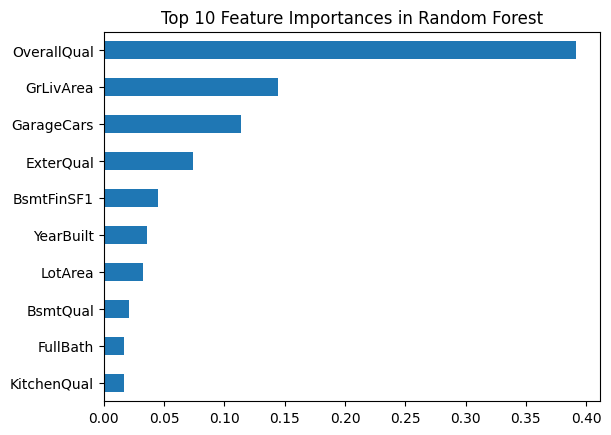

In [71]:
# Feature Importance
feature_importances = pd.Series(best_rf.feature_importances_, index=x_train_rf.columns)
feature_importances = feature_importances.sort_values(ascending=True)
feature_importances.tail(10).plot(kind='barh')

plt.title("Top 10 Feature Importances in Random Forest")
plt.show()

In [72]:
# Make Predictions
x_test_rf = x_test[x_train_rf.columns] # ensuring both train and test have same column
x_test_rf["Condition2_PosN"].fillna(0, inplace=True) # fill single cell with 0 ( mean )
y_pred = best_rf.predict(x_test_rf)

# Calculate Evaluation Metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100  # Convert to %

# Print Results
print(f"Random Forest RMSE: {rmse:.4f}")
print(f"Random Forest R²: {r2:.4f}")
print(f"Random Forest MAPE: {mape:.2f}%")

Random Forest RMSE: 29249.5942
Random Forest R²: 0.8800
Random Forest MAPE: 10.62%


In [73]:
# Make predictions using the final model
x_submission = data_test[x_train_rf.columns] # ensuring both train and test have same column
y_pred = best_rf.predict(x_submission)

# Create submission dataframe (assuming 'ID' column exists in data_test)
submission = pd.DataFrame({
    "Id": data_test["Id"],  # Use the ID from original test dataset
    "SalePrice": y_pred  # Predicted values
})

# Save submission file
submission.to_csv("RfModel.csv", index=False)
submission.shape

(1459, 2)

Root Mean Squared Logarithmic Error (RMSLE) 0.15269 
___________________________________________________________________________
Implementation of XG Boost

In [74]:
# P value & VIF check
ols_xgb, x_train_xgb= ols_pvfilter(x_train, y_train)

Removing BldgType_2fmCon (p=0.99474)| R²: 0.88358
Removing GarageYrBlt (p=0.99010)| R²: 0.88358
Removing Neighborhood_BrkSide (p=0.98476)| R²: 0.88358
Removing Heating (p=0.96512)| R²: 0.88358
Removing Neighborhood_MeadowV (p=0.89938)| R²: 0.88358
Removing PavedDrive (p=0.89446)| R²: 0.88358
Removing Condition2_RRAn (p=0.88498)| R²: 0.88358
Removing TotalBsmtSF (p=0.86089)| R²: 0.88358
Removing BsmtUnfSF (p=0.90703)| R²: 0.88358
Removing BsmtFinSF2 (p=0.87283)| R²: 0.88358
Removing Id (p=0.85963)| R²: 0.88357
Removing Age (p=0.85917)| R²: 0.88357
Removing YearRemodAdd (p=0.99301)| R²: 0.88357
Removing BsmtFinType2 (p=0.78727)| R²: 0.88357
Removing MiscVal (p=0.75019)| R²: 0.88356
Removing LandSlope (p=0.72986)| R²: 0.88355
Removing FireplaceQu (p=0.73231)| R²: 0.88354
Removing Neighborhood_Blueste (p=0.67815)| R²: 0.88352
Removing Condition1_RRNe (p=0.67698)| R²: 0.88351
Removing Condition2_RRNn (p=0.65829)| R²: 0.88349
Removing Neighborhood_Somerst (p=0.61227)| R²: 0.88347
Removing Ne

In [75]:
# Finding best params for XGBoost function
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

xgb_random = RandomizedSearchCV(XGBRegressor(), param_distributions=param_grid, 
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
xgb_random.fit(x_train_xgb, y_train)

print(f"Best Parameters: {xgb_random.best_params_}")

Best Parameters: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.2, 'colsample_bytree': 1.0}


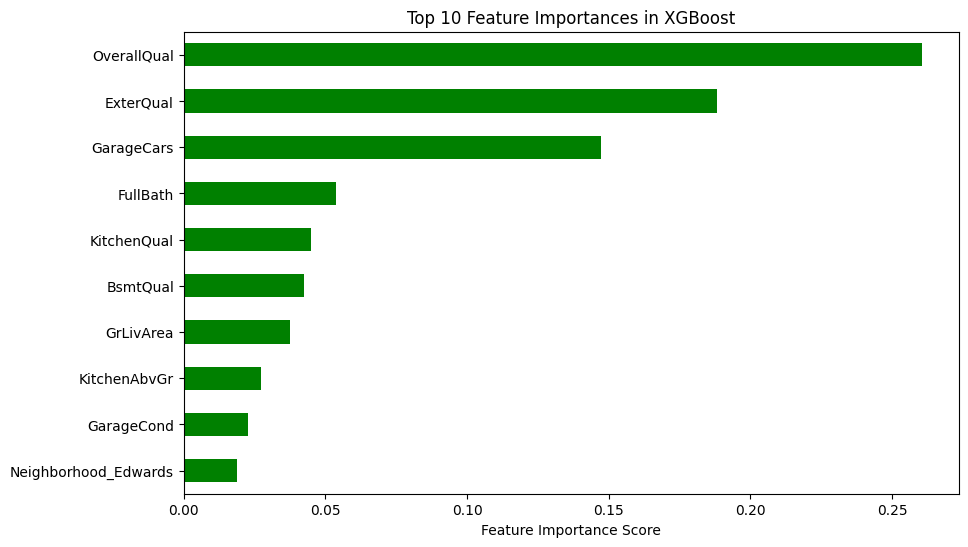

In [76]:
# Feature Importance
best_xgb = xgb_random.best_estimator_
feature_importance_xgb = pd.Series(best_xgb.feature_importances_, index=x_train_xgb.columns)
feature_importance_xgb = feature_importance_xgb.sort_values(ascending=False)

plt.figure(figsize=(10,6))
feature_importance_xgb.head(10).plot(kind='barh', color='green')
plt.gca().invert_yaxis()  
plt.title("Top 10 Feature Importances in XGBoost")
plt.xlabel("Feature Importance Score")
plt.show()

In [77]:
# Make Predictions
x_test_xgb = x_test[x_train_xgb.columns] # ensuring both train and test have same column
x_test_xgb["Condition2_PosN"].fillna(0, inplace=True) # fill single cell with 0 ( mean )
y_pred_xgb = best_xgb.predict(x_test_xgb)

# Compute Metrics
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))  # RMSE
r2_xgb = r2_score(y_test, y_pred_xgb)  # R² Score
mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb) * 100  # Convert to %

# Print Results
print(f"XGBoost RMSE: {rmse_xgb:.4f}")
print(f"XGBoost R²: {r2_xgb:.4f}")
print(f"XGBoost MAPE: {mape_xgb:.2f}%")

XGBoost RMSE: 32235.0046
XGBoost R²: 0.8543
XGBoost MAPE: 10.02%


In [78]:
# Make predictions using the final model
x_submission = data_test[x_train_xgb.columns] # ensuring both train and test have same column
y_pred = best_xgb.predict(x_submission)

# Create submission dataframe (assuming 'ID' column exists in data_test)
submission = pd.DataFrame({
    "Id": data_test["Id"],  # Use the ID from original test dataset
    "SalePrice": y_pred  # Predicted values
})

# Save submission file
submission.to_csv("xgbModel.csv", index=False)
submission.shape

(1459, 2)

Root Mean Squared Logarithmic Error (RMSLE) 0.13822
____________________________________________________________________________
Verify the usefulnes of P-value and VIF check, rebuild XGB model

In [79]:
# Finding best parameter for XGBoost 
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

xgb_random = RandomizedSearchCV(XGBRegressor(), param_distributions=param_grid, 
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
xgb_random.fit(x_train, y_train)

print(f"Best Parameters: {xgb_random.best_params_}")

Best Parameters: {'subsample': 0.7, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.7}


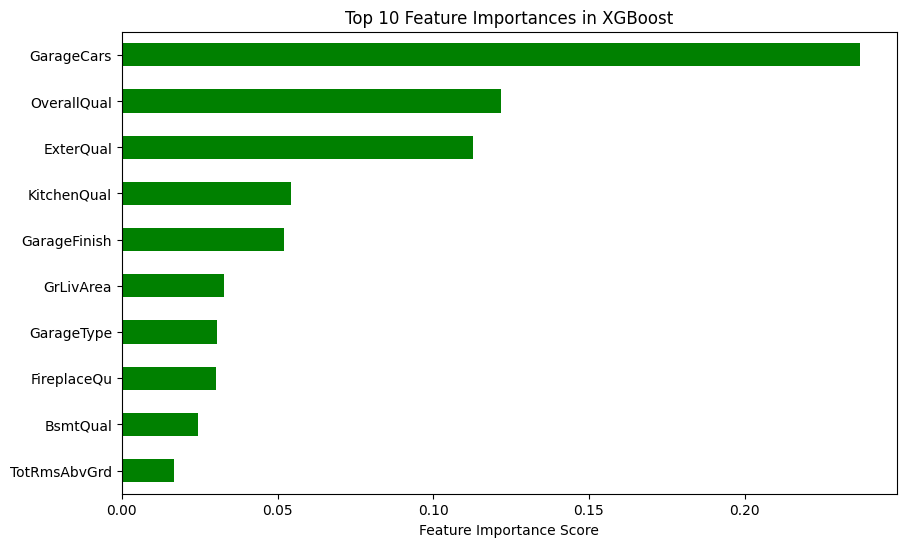

In [80]:
# Feature Importance
plain_xgb = xgb_random.best_estimator_
feature_importance_xgb = pd.Series(plain_xgb.feature_importances_, index=x_train.columns)
feature_importance_xgb = feature_importance_xgb.sort_values(ascending=False)

plt.figure(figsize=(10,6))
feature_importance_xgb.head(10).plot(kind='barh', color='green')
plt.gca().invert_yaxis()  
plt.title("Top 10 Feature Importances in XGBoost")
plt.xlabel("Feature Importance Score")
plt.show()

In [81]:
# Make Predictions
x_test_xgb = x_test[x_train.columns] # ensuring both train and test have same column
x_test_xgb["Condition2_PosN"].fillna(0, inplace=True) # fill single cell with 0 ( mean )
y_pred_xgb = plain_xgb.predict(x_test_xgb)

# Compute Metrics
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))  # RMSE
r2_xgb = r2_score(y_test, y_pred_xgb)  # R² Score
mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb) * 100  # Convert to %

# Print Results
print(f"XGBoost RMSE: {rmse_xgb:.4f}")
print(f"XGBoost R²: {r2_xgb:.4f}")
print(f"XGBoost MAPE: {mape_xgb:.2f}%")

XGBoost RMSE: 24033.0292
XGBoost R²: 0.9190
XGBoost MAPE: 9.44%


In [82]:
# Ensure both have the same columns
missing_cols = set(x_train.columns) - set(data_test.columns)
for col in missing_cols:
    data_test[col] = 0  # Or data_test[col] = x_train[col].mean()

x_submission = data_test[x_train.columns]  # Ensures correct order as well

# Make predictions using the final model
y_pred = plain_xgb.predict(x_submission)

# Create submission dataframe (assuming 'ID' column exists in data_test)
submission = pd.DataFrame({
    "Id": data_test["Id"],  # Use the ID from original test dataset
    "SalePrice": y_pred  # Predicted values
})

# Save submission file
submission.to_csv("xgplainModel.csv", index=False)
submission.shape

(1459, 2)

Root Mean Squared Logarithmic Error (RMSLE) 0.16135
____________________________________________________________________________
P-value check and VIF filter is useful
____________________________________________________________________________
XG Boost y var normality Tuning Trial

Shapiro-Wilk Test Statistic: 0.9910345426449241, p-value: 1.5072919887371587e-06


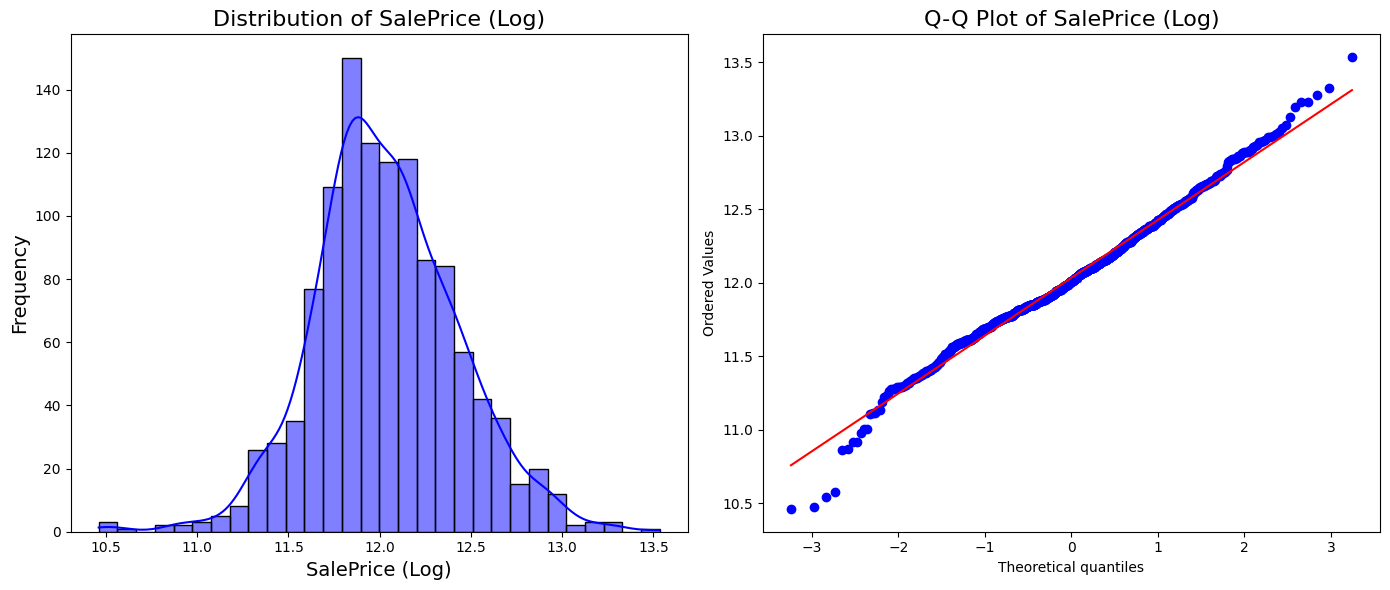

In [83]:
# SalePrice Normality Transformation
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# Shapiro wilk's test for normality 
stat, p = stats.shapiro(y_train_log)
print(f"Shapiro-Wilk Test Statistic: {stat}, p-value: {p}")

# Create a figure with 2 subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Histogram with KDE
sns.histplot(y_train_log, kde=True, bins=30, color='blue', ax=axes[0])
axes[0].set_title('Distribution of SalePrice (Log)', fontsize=16)
axes[0].set_xlabel('SalePrice (Log)', fontsize=14)
axes[0].set_ylabel('Frequency', fontsize=14)

# Q-Q plot
stats.probplot(y_train_log, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot of SalePrice (Log)', fontsize=16)

# Adjust layout and show
plt.tight_layout()
plt.show()

In [84]:
# Finding best parameter for XGBoost 
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

random_xgb = RandomizedSearchCV(XGBRegressor(), param_distributions=param_grid, 
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
random_xgb.fit(x_train_xgb, y_train_log) # ols_xgb pvcheck & normality for y 

print(f"Best Parameters: {random_xgb.best_params_}")

Best Parameters: {'subsample': 0.7, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.7}


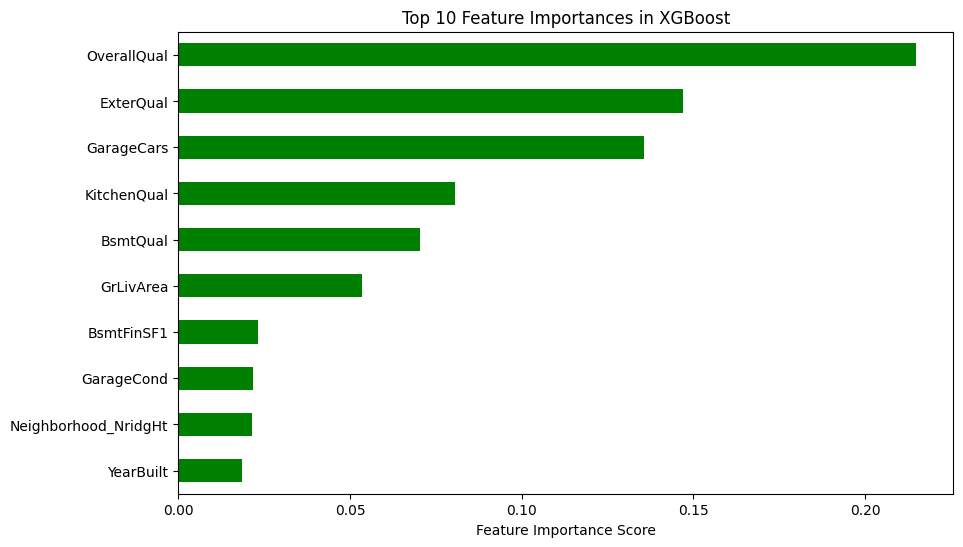

In [85]:
# Feature Importance
normal_xgb = random_xgb.best_estimator_
feature_importance_xgb = pd.Series(normal_xgb.feature_importances_, index=x_train_xgb.columns)
feature_importance_xgb = feature_importance_xgb.sort_values(ascending=False)

plt.figure(figsize=(10,6))
feature_importance_xgb.head(10).plot(kind='barh', color='green')
plt.gca().invert_yaxis()  
plt.title("Top 10 Feature Importances in XGBoost")
plt.xlabel("Feature Importance Score")
plt.show()

In [86]:
# Make Predictions
x_test_xgb = x_test[x_train_xgb.columns] # ensuring both train and test have same column
x_test_xgb["Condition2_PosN"].fillna(0, inplace=True) # fill single cell with 0 ( mean )
y_pred_xgb = normal_xgb.predict(x_test_xgb)

# Compute Metrics
rmse_xgb = np.sqrt(mean_squared_error(y_test_log, y_pred_xgb))  # RMSE
r2_xgb = r2_score(y_test_log, y_pred_xgb)  # R² Score
mape_xgb = mean_absolute_percentage_error(y_test_log, y_pred_xgb) * 100  # Convert to %

# Print Results
print(f"XGBoost RMSE: {rmse_xgb:.4f}")
print(f"XGBoost R²: {r2_xgb:.4f}")
print(f"XGBoost MAPE: {mape_xgb:.2f}%")

XGBoost RMSE: 0.1417
XGBoost R²: 0.8843
XGBoost MAPE: 0.76%


In [87]:
# Ensure both have the same columns
missing_cols = set(x_train_xgb.columns) - set(data_test.columns)
for col in missing_cols:
    data_test[col] = 0  # Or data_test[col] = x_train[col].mean()
x_submission = data_test[x_train_xgb.columns]  # Ensures correct order as well

# Make predictions using the final model
y_pred = normal_xgb.predict(x_submission)
y_pred = np.expm1(y_pred)

# Create submission dataframe (assuming 'ID' column exists in data_test)
submission = pd.DataFrame({
    "Id": data_test["Id"],  # Use the ID from original test dataset
    "SalePrice": y_pred  # Predicted values
})

# Save submission file
submission.to_csv("xgbnormal.csv", index=False)
submission.shape

(1459, 2)

Root Mean Squared Logarithmic Error (RMSLE) 0.13450
___________________________________________________________________________
Normality increases the accuracy of prediction 
___________________________________________________________________________
Fine Tuning the normalized model applying Feature Transformation


In [88]:
# Transformation 
x_tr_xgb_tf , x_te_xgb_tf, x_sub_xgb_tf = transformation_regression(x_train, x_test, data_test, y_train_log)

RoofMatl: Polynomial (Degree 3) | ΔR²: 0.00532
OverallQual: Polynomial (Degree 3) | ΔR²: 0.00063
GarageQual: Polynomial (Degree 3) | ΔR²: 0.00636
GarageCars: Polynomial (Degree 3) | ΔR²: 0.01186
GarageCond: Polynomial (Degree 3) | ΔR²: 0.01128
Functional: Polynomial (Degree 3) | ΔR²: 0.00134
FullBath: Polynomial (Degree 3) | ΔR²: 0.00138
BsmtFullBath: Polynomial (Degree 3) | ΔR²: 0.00340
OverallCond: Polynomial (Degree 3) | ΔR²: 0.08167
HalfBath: Polynomial (Degree 2) | ΔR²: 0.01285
Alley: Polynomial (Degree 2) | ΔR²: 0.02021
BldgType_Duplex: Exponential | ΔR²: 0.00000
BsmtQual: Polynomial (Degree 3) | ΔR²: 0.06985
KitchenAbvGr: Polynomial (Degree 2) | ΔR²: 0.00176
KitchenQual: Polynomial (Degree 3) | ΔR²: 0.00286
LandContour: Polynomial (Degree 3) | ΔR²: 0.03082
BsmtExposure: Polynomial (Degree 3) | ΔR²: 0.01450
Neighborhood_CollgCr: Exponential | ΔR²: 0.00000
HeatingQC: Polynomial (Degree 3) | ΔR²: 0.00741
LandSlope: Polynomial (Degree 2) | ΔR²: 0.00033
BsmtHalfBath: Polynomial (Degr

In [89]:
# P VIF Check
ols_xgb_pv_log_tf, x_tr_xgb_pv_tf = ols_pvfilter(x_tr_xgb_tf, y_train_log)

Removing MiscVal^3 (p=0.99977)| R²: 0.93076
Removing GarageQual^3 (p=0.98091)| R²: 0.93061
Removing Neighborhood_CollgCr (p=0.99608)| R²: 0.92996
Removing Exterior2nd^3 (p=0.99262)| R²: 0.93186
Removing Neighborhood_Edwards (p=0.99919)| R²: 0.93197
Removing BsmtFinType2 (p=0.99997)| R²: 0.93044
Removing RemodelAge^2 (p=0.98657)| R²: 0.93124
Removing GrLivArea (p=0.99874)| R²: 0.93149
Removing GarageArea (p=0.99811)| R²: 0.93116
Removing BsmtFinType1 (p=0.99980)| R²: 0.93095
Removing PoolArea^3 (p=0.97946)| R²: 0.93091
Removing 3SsnPorch^3 (p=0.99971)| R²: 0.93113
Removing YrSold (p=0.97200)| R²: 0.93210
Removing LandSlope (p=0.99572)| R²: 0.93104
Removing 3SsnPorch (p=0.98545)| R²: 0.93109
Removing GarageArea^2 (p=0.99998)| R²: 0.93094
Removing BsmtFinType2^3 (p=0.99619)| R²: 0.93095
Removing Neighborhood_Mitchel (p=0.98393)| R²: 0.93089
Removing EnclosedPorch (p=0.99612)| R²: 0.93084
Removing BldgType_Twnhs (p=0.99406)| R²: 0.93078
Removing LandSlope^2 (p=0.98892)| R²: 0.93080
Removin

In [90]:
# Finding best parameter for XGBoost 
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

random_xgb = RandomizedSearchCV(XGBRegressor(), param_distributions=param_grid, 
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
random_xgb.fit(x_tr_xgb_pv_tf, y_train_log) # ols_xgb pvcheck & normality for y 

print(f"Best Parameters: {random_xgb.best_params_}")

Best Parameters: {'subsample': 0.7, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.8}


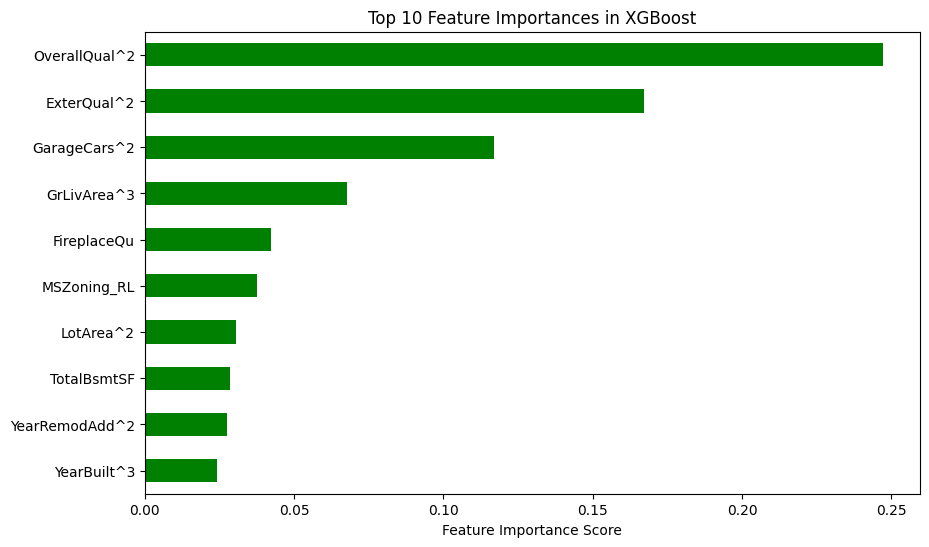

In [91]:
# Feature Importance
xgb_pv_log_tf = random_xgb.best_estimator_
feature_importance_xgb = pd.Series(xgb_pv_log_tf.feature_importances_, index=x_tr_xgb_pv_tf.columns)
feature_importance_xgb = feature_importance_xgb.sort_values(ascending=False)

plt.figure(figsize=(10,6))
feature_importance_xgb.head(10).plot(kind='barh', color='green')
plt.gca().invert_yaxis()  
plt.title("Top 10 Feature Importances in XGBoost")
plt.xlabel("Feature Importance Score")
plt.show()

In [92]:
# Make Predictions
x_test_xgb = x_te_xgb_tf[x_tr_xgb_pv_tf.columns] # ensuring both train and test have same column
x_test_xgb["Condition2_PosN"].fillna(0, inplace=True) # fill single cell with 0 ( mean )
y_pred_xgb = xgb_pv_log_tf.predict(x_test_xgb)

# Compute Metrics
rmse_xgb = np.sqrt(mean_squared_error(y_test_log, y_pred_xgb))  # RMSE
r2_xgb = r2_score(y_test_log, y_pred_xgb)  # R² Score
mape_xgb = mean_absolute_percentage_error(y_test_log, y_pred_xgb) * 100  # Convert to %

# Print Results
print(f"XGBoost RMSE: {rmse_xgb:.4f}")
print(f"XGBoost R²: {r2_xgb:.4f}")
print(f"XGBoost MAPE: {mape_xgb:.2f}%")

XGBoost RMSE: 0.1270
XGBoost R²: 0.9071
XGBoost MAPE: 0.71%


In [93]:
# Ensure both have the same columns
missing_cols = set(x_tr_xgb_pv_tf.columns) - set(x_sub_xgb_tf.columns)
for col in missing_cols:
    x_sub_xgb_tf[col] = 0  

x_submission = x_sub_xgb_tf[x_tr_xgb_pv_tf.columns]  # Ensures correct order as well

# Make predictions using the final model
y_pred = xgb_pv_log_tf.predict(x_submission)
y_pred = np.expm1(y_pred) # unlog

# Create submission dataframe (assuming 'ID' column exists in data_test)
submission = pd.DataFrame({
    "Id": data_test["Id"],  # Use the ID from original test dataset
    "SalePrice": y_pred  # Predicted values
})

# Save submission file
submission.to_csv("xgnormal&transform.csv", index=False)
submission.shape

(1459, 2)

Root Mean Squared Logarithmic Error (RMSLE) 0.13388
______________________________________________________________________________
Normality and Transformation is useful
______________________________________________________________________________
XG Boost deep tuning for best result 